# Modèle prédictif

### Architecture du projet

 - Projet/Preprocessing : Configuration et sélection de la donnée
 
 - Projet/Modeles : Différents modèles et leur sauvegarde
 
 - Projet/Config : Les hyperparamètres principaux du projet
 
 - Projet/Results : Les différents résultats en fichier .csv
 
 - Projet/Data : Les données brutes
 
 - Projet/TrainingData : Les données traitées

 - requirements.txt : Installation des librairies
 
 - Main.py : Le fichier principale
 
 - Presentation.ipynb : Ce fichier
 
 - UserGuide.md/README.md : Guide d'utilisation du modèle et présentation du projet
 
 - Les fichiers trop volumineux sont dans le .gitignore donc pas présent sur github

### Documentation

En premier lieu, je me suis documenté sur ce qui impactait la valeur d'un logement

Les critères principaux sont :

 - La situation du bien
 - Son état
 - Terrain extéreur
 - Étage (Pour les appartements)
 - Différents lots

Références :

 - [1] : https://immobilier.lefigaro.fr/annonces/edito/acheter/les-prix-de-l-immobilier/immobilier-comment-estimer-plus-facilement-votre-bien-grace-au-big-data

 - [2] : https://www.economie.gouv.fr/cedef/estimer-prix-immobilier
 
 - [3] : https://www.kaggle.com/erick5/predicting-house-prices-with-machine-learning
 
### Les données sont dèja filtrées selon les paramètres suivant :

 - Suppression des colonnes vides
 - Suppression des doublons (lignes identiques)
 - On garde uniquement les ventes sur des Maisons et Appartements
 - Afin de s'assurer de la qualité des données, je choisis de supprimer les ventes de moins de 10 000€
 - Choix d'une ville, car les prix son très dépendant de la situation géographique d'un bien
 - Je choisis également de supprimer les ventes de plus de 1 500 000€ (car trop particulier comme vente)
 - Conversion en réel et on garde uniquement les colonnes que j'ai estimé pertinentes 
 
Après avoir choisit une ville, je choisis les colonnes des données que j'ai considéré utile à la prédiction.

### Colonnes pertinentes :

 - Valeur Foncière : Target donc obligatoire
 - Nombre de lots dans une maison 
 - Les surfaces Carrez des différents lots (Plus de 1m80 de plafond)
 - Type local
 - Type de voie (Encoder avec LabelEncoder())
 - Code Commune (Encoder avec LabelEncoder())
 - Surface réelle
 - Nombre de pièces principales
 - Surface terrain
 
Les données brutes ont déjà été traitées et sélectionnées comme voulu ci-dessus via les fonctions config() et select() de Main.py

### Importations nécessaires

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import r2_score,mean_absolute_error
from scipy import stats
from joblib import load

# On importe les données afin de les analyser visuellement 
nantes = pd.read_csv('Projet/Data/NANTES_44_data.csv')
lyon = pd.read_csv('Projet/Data/LYON_69_data.csv')
marseille = pd.read_csv('Projet/Data/MARSEILLE_13_data.csv')

### Analyse des données

Permet d'analyser la répartition des valeurs foncières et également la corrélation entre les différentes caractéristiques 

In [2]:
def analyse(data,heatmap = True) :
    
    #Describe
    print(data['Valeur fonciere'].describe())
    
    # Len
    print("")
    print("Taille de l'échantillon : {}".format(len(data['Valeur fonciere'])))
    
    # Probability plot
    res = stats.probplot(data['Valeur fonciere'], plot=plt)
    if heatmap :
        # Top 10 HeatMap
        matrice = data.corr()
        k = 10 # Nombre de variables à garder dans la HeatMap
        cols = matrice.nlargest(k, 'Valeur fonciere')['Valeur fonciere'].index
        cm = np.corrcoef(data[cols].values.T)
        sns.set(font_scale=1.0)
        f, ax = plt.subplots(figsize=(12, 6))
        hm = sns.heatmap(cm, annot=True, square=True, 
                         annot_kws={'size': 9}, yticklabels=cols.values, xticklabels=cols.values)

### Analyse des trois villes

count    1.437700e+04
mean     2.159338e+05
std      1.863696e+05
min      1.000000e+04
25%      1.000000e+05
50%      1.570000e+05
75%      2.650000e+05
max      1.500000e+06
Name: Valeur fonciere, dtype: float64

Taille de l'échantillon : 14377


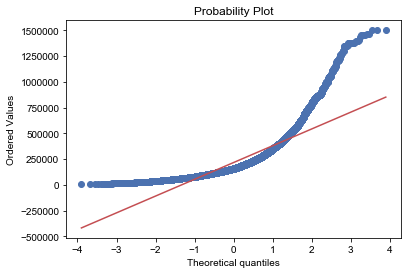

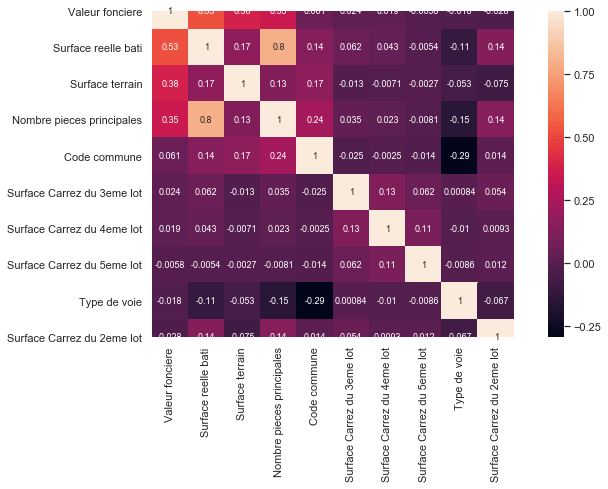

In [3]:
analyse(marseille)
#analyse(nantes)
#analyse(lyon)

### Visualition de la répartition de la valeur fonciere
Permet de visualiser la répartition des valeurs foncières et de la comparer à une répartition normale

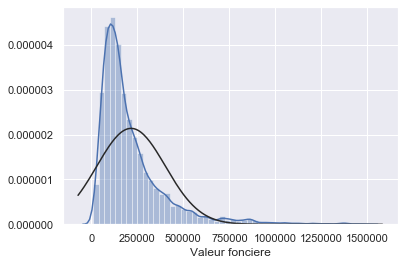

In [4]:
def visualisation(data) :
    sns.distplot(data['Valeur fonciere'] , fit=stats.norm)

visualisation(marseille)
#visualisation(nantes)
#visualisation(lyon)

On obtient une distribution qui n'est pas normal, il n'y a pas assez de données pour les valeurs foncières de plus de
750 000€.

### On cherche alors à "normaliser" la distribution car :
    
  - Si les données sont trop éparses, l'algorithme ne peut pas apprendre correctement 
    
  - Trop peu d'exemples pour les grandes valeurs
    
  - Les grandes valeurs auront trop d'influence sur la loss des modèles

Une technique pour normaliser cela est d'utiliser la fonction ln(1+x) (Filtre passe bas)

### Normalisation
Cette fonction applique ln(1+X) aux valeurs foncières 

In [5]:
def normalize(data) :
    df = data.copy()
    # Application de la fonction
    df["Valeur fonciere"] = np.log1p(df["Valeur fonciere"])

    # Vérification de la nouvelle distribution 
    sns.distplot(df['Valeur fonciere'] , fit=stats.norm)

### Pour les trois villes

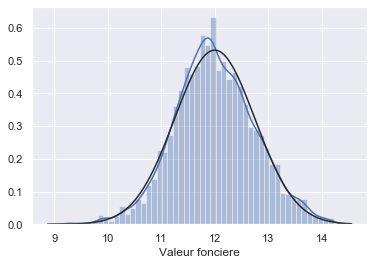

In [6]:
normalize(marseille)
#normalize(nantes)
#normalize(lyon)  

On obtient alors une distribution quasi-normale pour toutes les villes

C'est donc pour cela que j'ai appliqué la fonction ln(1+X) à la colonne valeur foncière des données dans le projet

### Analyse des données avec la valeur fonciere normalisée 

Récupération :

In [7]:
nantes_normalised = pd.read_csv('Projet/TrainingData/NANTES_44_training_data.csv')
lyon_normalised = pd.read_csv('Projet/TrainingData/LYON_69_training_data.csv')
marseille_normalised = pd.read_csv('Projet/TrainingData/MARSEILLE_13_training_data.csv')

Analyse des trois villes :

count    14377.000000
mean        11.998576
std          0.750292
min          9.210440
25%         11.512935
50%         11.964007
75%         12.487489
max         14.220976
Name: Valeur fonciere, dtype: float64

Taille de l'échantillon : 14377


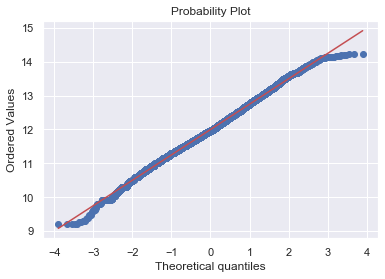

In [8]:
analyse(marseille_normalised,heatmap = False)
#analyse(nantes_normalised,heatmap = False)
#analyse(lyon_normalise,heatmap = Falsed)

On peut remarquer alors que l'on obtient bien une droite de répartition. Par contre il manque peut-être des données pour les valeurs foncières basses et hautes.

### Type de modèle

Je propose ici de comparer 3 modèles fréquemment utilisé dans les problèmes de régression et de choisir le modèle le plus performant en fonction de certaines métriques.

#### Réseau de neurones

- J'ai choisi ici un réseau de neurones classique composé de 3 couches, entrainé avec l'optimizer Adam sur 100 époques

#### XGBoost

- J'ai choisi d'utiliser également le xgb, que j'avais déjà utilisé pour un problème de régression. Il est normalement assez efficace sur ce type de problème. Ce régresseur met en œuvre des méthodes de gradient boosting et il se base sur des arbres décisionnels.

#### Random Forest Regressor

 - Le random forest regressor, il s'agit d'un régresseur que j'ai déjà étudié et utilisé il est également facilement explicable. Ce régresseur se compose de plusieurs forêts d'arbres décisionnels.

### Chargement des données :

In [9]:
# Chargement des données de l'apprentissage du nn

results_nantes_nn = pd.read_csv("Projet/Results/NN_results_NANTES_44.csv")
results_lyon_nn = pd.read_csv("Projet/Results/NN_results_LYON_69.csv")
results_marseille_nn = pd.read_csv("Projet/Results/NN_results_MARSEILLE_13.csv")

# Chargement des données de l'apprentissage du xgb

results_nantes_xgb = pd.read_csv("Projet/Results/XGB_results_NANTES_44.csv")
results_lyon_xgb = pd.read_csv("Projet/Results/XGB_results_LYON_69.csv")
results_marseille_xgb = pd.read_csv("Projet/Results/XGB_results_MARSEILLE_13.csv")

# Chargement des données de l'apprentissage du Random Forest Regressor

results_nantes_rfr = pd.read_csv("Projet/Results/RFR_results_NANTES_44.csv")
results_lyon_rfr = pd.read_csv("Projet/Results/RFR_results_LYON_69.csv")
results_marseille_rfr = pd.read_csv("Projet/Results/RFR_results_MARSEILLE_13.csv")

Fonction permettant d'analyser l’apprentissage :

In [10]:
def analyze_training(data) :
    print("")
    print(" Last val_mae = {}".format(data['val_mae'].iloc[-1]))
    print(" Last mae = {}".format(data['mae'].iloc[-1]))
    plt.plot(data['val_mae'])
    plt.plot(data['mae'])
    plt.legend(['val_mae','mae'])

### Analyse de l'entraînement du réseau de neurones


 Last val_mae = 0.3227865695953369
 Last mae = 0.3223453164100647


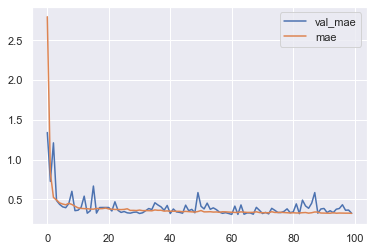

In [11]:
analyze_training(results_marseille_nn)
#analyze_training(results_nantes_nn)
#analyze_training(results_lyon_nn)

### Analyse de l'entraînement du régresseur XGBoost


 Last val_mae = 0.29634
 Last mae = 0.283012


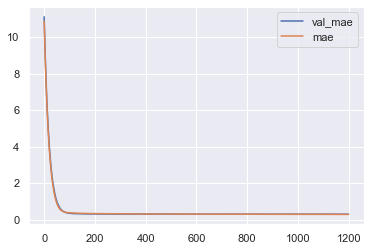

In [12]:
analyze_training(results_marseille_xgb)
#analyze_training(results_nantes_xgb)
#analyze_training(results_lyon_xgb)

### Analyse de l'entraînement du régresseur Random Forest Regressor

In [13]:
print('Val mae Marseille = {}'.format(results_marseille_rfr['val_mae'][0]))
print('Val mae Nantes = {}'.format(results_nantes_rfr['val_mae'][0]))
print('Val mae Lyon = {}'.format(results_lyon_rfr['val_mae'][0]))

Val mae Marseille = 0.3086613514370942
Val mae Nantes = 0.26763998191614696
Val mae Lyon = 0.3117517132334197


### Conclusion

#### XGB  :

 - L'apprentissage s'est fait en 200 époques un peu près
 - L'erreur est quasi-identique sur le set de validation que sur celui d’entraînement 
 - Semble être le meilleur des trois

#### NN :

 - Le modèle semble avoir appris
 - Petite fluctuation de l'erreur sur le set de validation du à l’apprentissage entre deux validations

#### RFR

 - Je n'ai que les données sur l'erreur sur le set de validation
 - Semble avoir appris au vu de la valeur de l'erreur
 

### Afficher l'importance de chaque paramètre 

Chargement :

In [14]:
rfr_marseille = load("Projet/Modeles/PreTrained/RFR_MARSEILLE_13.joblib")
rfr_nantes = load("Projet/Modeles/PreTrained/RFR_NANTES_44.joblib")
rfr_lyon = load("Projet/Modeles/PreTrained/RFR_LYON_69.joblib")

Fonction d'affichage de l'importance de chaque caractéristique :

In [15]:
def logImportances(reg,df) :
    # On supprime la target
    data = df.copy()
    del data['Valeur fonciere']
    
    # les écart types pour chaque foret
    importances = reg.feature_importances_
    std = np.std([forest.feature_importances_ for forest in reg.estimators_], axis=0)
    indices = np.argsort(importances)[::-1]
    
    # On récupèrer les labels 
    X = np.array(data)
    list_column = data.columns.tolist()
    print("Classement des caractéristiques :")
    print("")
    for f in range(X.shape[1]-1):
        print("%d. %s %d (%f)" % (f, list_column[indices[f]], indices[f], importances[indices[f]]))
        
    # On trace
    plt.figure(figsize=(20,10))
    plt.title("Importance de chaque paramètre")
    plt.bar(range(X.shape[1]), importances[indices],
       color="salmon", yerr=std[indices], align="center")
    plt.xticks(range(X.shape[1]), indices)
    plt.xlim([-1, X.shape[1]])
    plt.show()

Affichage pour chaque ville :

Classement des caractéristiques :

0. Surface reelle bati 3 (0.564104)
1. Surface Carrez du 1er lot 7 (0.130216)
2. Code commune 6 (0.112520)
3. Surface terrain 5 (0.067273)
4. Nombre de lots 0 (0.045049)
5. Surface Carrez du 2eme lot 8 (0.035274)
6. Type de voie 1 (0.018864)
7. Nombre pieces principales 4 (0.017365)
8. Code type local 2 (0.007190)
9. Surface Carrez du 3eme lot 9 (0.002043)
10. Surface Carrez du 4eme lot 10 (0.000103)


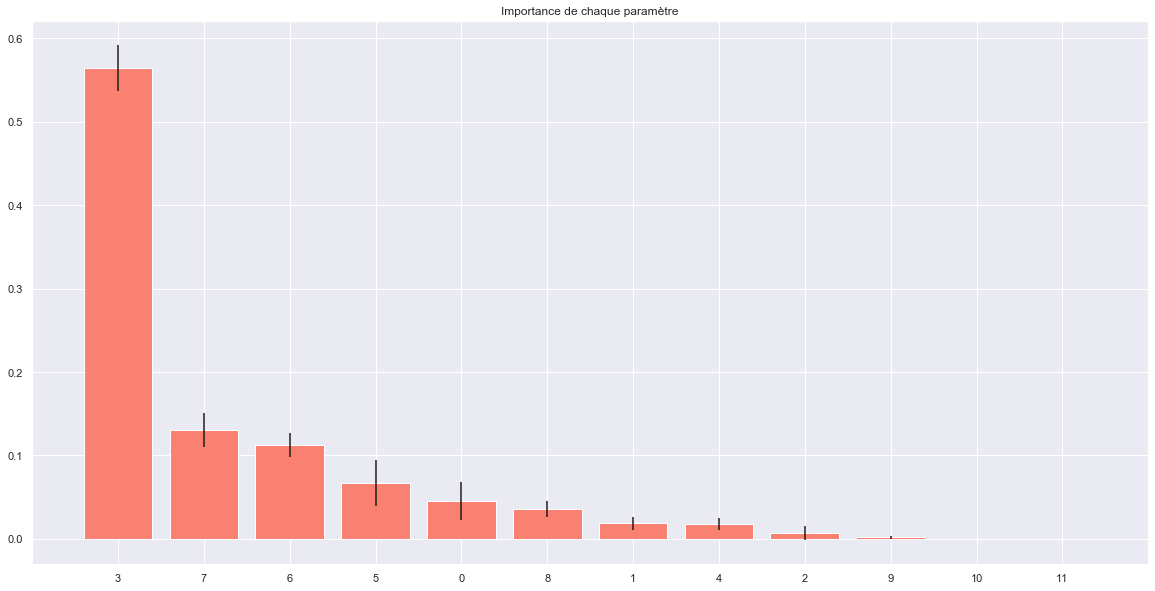

In [16]:
#logImportances(rfr_marseille,marseille_normalised)
#logImportances(rfr_nantes,nantes_normalised)
logImportances(rfr_lyon,lyon_normalised)

### Remarques :

 - Les barres noires représentent les écarts types pour chaque forêt du régresseur
 - On remarque que l'importance des caractéristiques change en fonction des villes
 - La surface réelle du bâti semble être la donnée la plus importante


### Présentation des résultats finaux

Chargement des données :

In [17]:
test_marseille_rfr = pd.read_csv('Projet/Results/RFR_test_MARSEILLE_13.csv')
test_marseille_xgb = pd.read_csv('Projet/Results/XGB_test_MARSEILLE_13.csv')
test_marseille_nn = pd.read_csv('Projet/Results/NN_test_MARSEILLE_13.csv')

test_nantes_rfr = pd.read_csv('Projet/Results/RFR_test_NANTES_44.csv')
test_nantes_xgb = pd.read_csv('Projet/Results/XGB_test_NANTES_44.csv')
test_nantes_nn = pd.read_csv('Projet/Results/NN_test_NANTES_44.csv')

test_lyon_rfr = pd.read_csv('Projet/Results/RFR_test_LYON_69.csv')
test_lyon_xgb = pd.read_csv('Projet/Results/XGB_test_LYON_69.csv')
test_lyon_nn = pd.read_csv('Projet/Results/NN_test_LYON_69.csv')

Fonction d'analyse des tests :

In [18]:
def plotTest(df) :
    data = df.copy()
    data = data.sort_values(by=['Y_pred'],ascending = [True])
    data.reset_index(inplace = True,drop = True)
    print("")
    print("R2 score = {}".format(r2_score(data['Y_true'],data['Y_pred'])))
    print("MAE = {}".format(mean_absolute_error(data['Y_true'],data['Y_pred'])))
    print("Erreur moyenne en pct = {}".format(np.mean(abs(data['Y_true']-data['Y_pred'])/data['Y_true'])))
    plt.title("Prédiction vs Label")
    plt.plot(data['Y_true'])
    plt.plot(data['Y_pred'])
    plt.legend(['Y_true','Y_pred'])
    plt.show()


### Analyse de chaque ville et de chaque régresseur :

Pour Marseille :


R2 score = 0.6830661071753665
MAE = 66285.3928384512
Erreur moyenne en pct = 0.2809513107702598


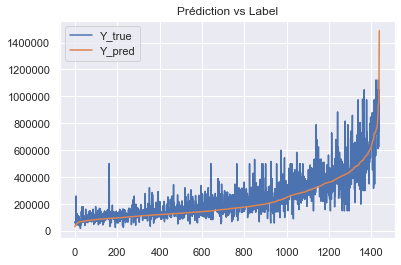

In [19]:
plotTest(test_marseille_xgb)
#plotTest(test_marseille_rfr)
#plotTest(test_marseille_nn)

Pour Nantes : 


R2 score = 0.48064558505378785
MAE = 88393.59784631361
Erreur moyenne en pct = 0.39457193713341304


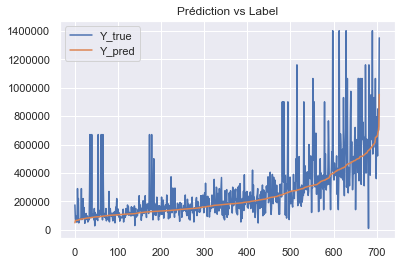

In [20]:
plotTest(test_nantes_xgb)
#plotTest(test_nantes_rfr)
#plotTest(test_nantes_nn)

Pour Lyon :


R2 score = 0.4764279464387333
MAE = 78019.21729773775
Erreur moyenne en pct = 0.33978694366592765


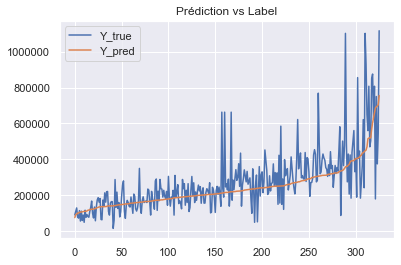

In [21]:
plotTest(test_lyon_xgb)
#plotTest(test_lyon_rfr)
#plotTest(test_lyon_nn)


### Conclusion :

 - Le meilleur modèle semble être le xgb au vu des résultats
 - Les modèles suivent la moyenne des prix
 - Des résultats très différents entre les villes   

### Critiques : 

 - Les choix au début, peut-être prendre un prix au m2 pour trier les données et non juste un prix
 
 - Un R2 score max de 0.68, pas assez fiable je pense pour une mise en production (R2 score max = 1.0)

 - Un écart moyen de plus de 60000€, donc pas utilisable pour une utilisation professionnelle 


### Possibles améliorations :

 - Disposer de plus de données pour Lyon et Nantes

 - LabelEncoder utilisé n'est pas enregistré donc peut être une modification à faire

 - Une meilleure optimisation des modèles

 - Choix des colonnes (Oublie potentiel de données importantes)

 - Manque des données sur l'état de l'habitation, l'étage, qualité, autres caractéristiques (Piscine,Garage,...)
 
 - Avoir une donnée sur le quartier où est situé le bien
             